In [1]:
%matplotlib widget

In [2]:
from datetime import datetime, timedelta
import calendar
from glob import glob
import json
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import Button, FileUpload, GridspecLayout

In [3]:
plt.ioff()

fig = plt.figure(figsize=(9, 3))
fig.set_tight_layout(dict(pad=0))

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

fig.patch.set_facecolor('white')

In [8]:
def update_figure(path):
    global ax
    global fig

    data = []

    for file in sorted(glob(str(pathlib.Path(path) / 'StreamingHistory*.json'))):
        with open(file, encoding="utf8") as fobj:
            data.extend(json.load(fobj))

    streaming_history = pd.DataFrame(data)
    streaming_history['endTime'] = pd.to_datetime(streaming_history['endTime'])
    streaming_history["date"] = streaming_history["endTime"].dt.floor('d')

    by_date = streaming_history.groupby("date")[["trackName"]].count()
    by_date = by_date.sort_index()

    by_date["weekday"] = by_date.index.weekday
    by_date["week"] = by_date.index.week

    week = 0
    prev_week = by_date.iloc[0]["week"]
    continuous_week = np.zeros(len(by_date)).astype(int)
    sunday_dates = []
    for i, (_, row) in enumerate(by_date.iterrows()):
        if row["week"] != prev_week:
            week += 1
            prev_week = row["week"]
        continuous_week[i] = week
    by_date["continuous_week"] = continuous_week

    songs = np.full((7, continuous_week.max()+1), np.nan)

    for index, row in by_date.iterrows():
        songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

    min_date = streaming_history["endTime"].min()
    first_monday = min_date - timedelta(min_date.weekday())
    mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
    x_labels = [calendar.month_abbr[mons[0].month]]
    x_labels.extend([
        calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
        for i in range(1, len(mons))])

    y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

    songs = np.nan_to_num(songs)

    plt.clf()

    ax = plt.subplot()

    ax.xaxis.tick_top()
    ax.tick_params(axis='both', which='both', length=0, labelsize=7)
    ax.set_facecolor("white")

    ax.set_title('{:,} songs listened in the last year'.format(int(np.sum(songs))), loc='left')

    sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            cmap="Greens", cbar=True, cbar_kws=dict(orientation='horizontal', shrink=0.4),
            vmin=0, vmax=np.max(songs), ax=ax)

    ax.set_yticklabels(y_labels, rotation=0)
    ax.set_xticklabels(x_labels, ha="left")

    fig.canvas.draw()
    fig.canvas.flush_events()

# Your year on Spotify!

This work was inspired by [Más visualización con tus datos de Spotify con Python](https://tacosdedatos.com/mas-data-viz-con-spotify-python), also available [in english](https://dev.to/fferegrino/plotting-your-spotify-data-2km8).

How does it work?

First request your data on Spotify following this link: https://www.spotify.com/account/privacy

Then come back to this dashboard and upload all the `StreamingHistory*.json` files (don't worry, nothing is saved permanently onto the server, at least not if you see this application from https://voila-gallery.org) and click on the `Show` button!

In [9]:
layout = GridspecLayout(20, 3, height='600px')

def on_sample_data_click(event):
    update_figure('spotifyData')

def on_upload(change):
    value = change['new']

    for filename in value:
        with open(filename, 'wb', encoding="utf8") as outfile:
            outfile.write(value[filename]['content'])

def show(event):
    update_figure('.')

load_sample_data = Button(description='Show Spotify data', layout=dict(width='auto', height='auto'))
load_sample_data.on_click(on_sample_data_click)

upload_data = FileUpload(description='Upload your data:', layout=dict(width='auto', height='auto'))
upload_data.observe(on_upload, 'value')

plot = Button(description='Show', button_style='success', layout=dict(width='auto', height='auto'))
plot.on_click(show)


layout[0, 0] = load_sample_data
layout[1, 0] = upload_data
layout[1, 1] = plot

layout[3:, :] = fig.canvas

layout

GridspecLayout(children=(Button(description='Show Spotify data', layout=Layout(grid_area='widget001', height='…

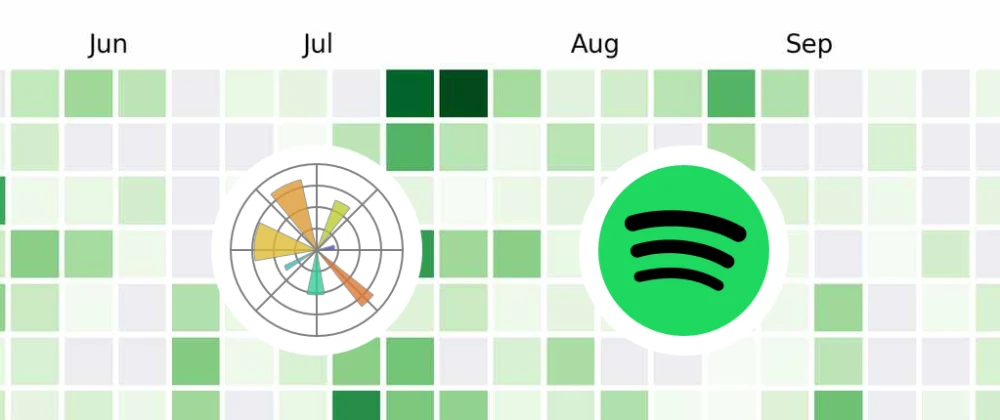

In [17]:
from glob import glob
import json
import pandas as pd

import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

def read_history():
    history = []
    for file in sorted(glob("StreamingHistory*.json")):
        with open(file, encoding="utf8") as readable:
            history.extend(json.load(readable))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history

streaming_history = read_history()
streaming_history.head(5)

,endTime,artistName,trackName,msPlayed
0,2020-06-10 16:56:00,Alphaville,Forever Young,35538
1,2020-06-10 16:57:00,Pink Floyd,Time - 2011 Remastered Version,15956
2,2020-06-10 16:57:00,Noir Désir,L'homme pressé,55692
3,2020-06-10 16:58:00,Pink Floyd,"Shine On You Crazy Diamond, Pts. 6-9 - 2011 Re...",29094
4,2020-06-10 16:58:00,Pink Floyd,"Shine On You Crazy Diamond, Pts. 1-5 - 2011 Re...",34683


In [5]:
streaming_history["date"] = streaming_history["endTime"].dt.floor('d')
by_date = streaming_history.groupby("date")[["trackName"]].count()
by_date = by_date.sort_index()
by_date["weekday"] = by_date.index.weekday
by_date["week"] = by_date.index.week
by_date

,trackName,weekday,week
date,,,
2020-06-10,76,2,24
2020-06-12,14,4,24
2020-06-18,39,3,25


In [9]:
week = 0
prev_week = by_date.iloc[0]["week"]
continuous_week = np.zeros(len(by_date)).astype(int)
sunday_dates = []
for i, (_, row) in enumerate(by_date.iterrows()):
    if row["week"] != prev_week:
        week += 1
        prev_week = row["week"]
    continuous_week[i] = week
by_date["continuous_week"] = continuous_week 
by_date.head()

,trackName,weekday,week,continuous_week
date,,,,
2020-06-10,76,2,24,0
2020-06-12,14,4,24,0
2020-06-18,39,3,25,1


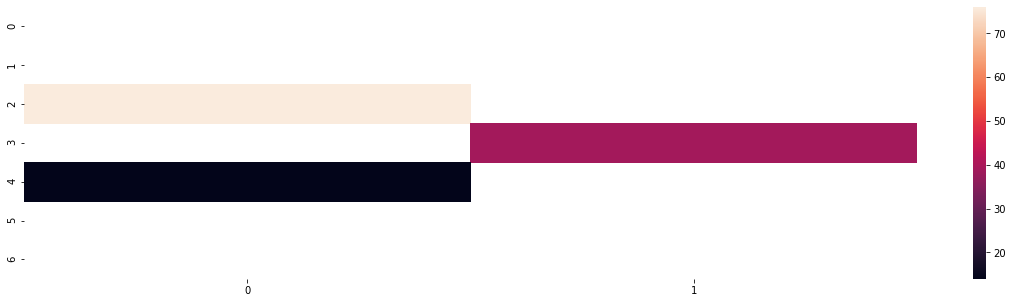

In [15]:
songs = np.full((7, continuous_week.max()+1), np.nan)

for index, row in by_date.iterrows():
    songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

fig = plt.figure(figsize=(20,5))
ax = plt.subplot()
mask = np.isnan(songs)
sns.heatmap(songs, ax = ax)

In [18]:
min_date = streaming_history["endTime"].min()
first_monday = min_date - timedelta(min_date.weekday())
mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
x_labels = [calendar.month_abbr[mons[0].month]]
x_labels.extend([
    calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
    for i in range(1, len(mons))])

y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

[Text(0.5, 1, 'Jun')]

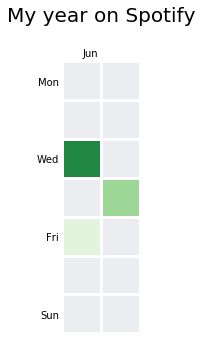

In [20]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot()

ax.set_title("My year on Spotify", fontsize=20,pad=40)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both',length=0)
ax.set_facecolor("#ebedf0") 
fig.patch.set_facecolor('white')

sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            mask=np.isnan(songs), cmap="Greens",
            vmin=0, vmax=100, cbar=False, ax=ax)

ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, ha="left")